# An Analysis of the Server Room Power Consumption
## 1. Import Data
First, let's use the pandas library to import the data and store it.

In [238]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

dl1 = pd.read_csv("../data/DL1March_May_24.csv").drop(columns="No.").drop(0)
dl3 = pd.read_csv("../data/DL3March_May_24.csv").drop(columns="No.").drop(0)

dl1["Date/Time"] = pd.to_datetime(dl1["Date/Time"], format='%d/%m/%Y %H:%M')
dl3["Date/Time"] = pd.to_datetime(dl3["Date/Time"], format='%d/%m/%Y %H:%M')

# print(dl1.head())
# it is quite obvious that the first row of values are outliers, so they are removed

### Key Analyses to Perform
1. **Time-Series Analysis**
    1. Energy Consumption Over Time:
        - Objective: Identify overall trends in energy usage. Are there periods of high consumption? How does energy use vary by day or hour?
        - Analysis: Plot energy consumption over time. Break down by day, week, and month to identify patterns (e.g., higher usage during workdays vs. weekends).
    2. Instantaneous Power and Current:
        - Objective: Examine how power consumption and current vary over time.
        - Analysis: Plot these variables against time. Look for spikes or irregularities that could indicate issues with equipment or unusual activity.
    3. Cost Analysis:
        - Objective: Correlate energy consumption with costs to identify cost-saving opportunities.
        - Analysis: Plot cost versus energy consumption over time. Look for periods where costs may be disproportionately high compared to energy use.

2. **Efficiency Analysis**
    1. Power Factor Analysis:
        - Objective: Assess the efficiency of energy use.
        - Analysis: Evaluate the power factor over time. A lower power factor suggests inefficiency, possibly due to the presence of inductive loads like motors or transformers. Identify periods of low power factor and investigate causes.
    2. Correlation Between Variables:
        - Objective: Understand relationships between power consumption, current, and power factor.
        - Analysis: Use scatter plots or correlation matrices to explore how these variables relate. For example, check if lower power factors correlate with higher currents or power usage.

3. **Peak Demand and Load Analysis**
    1. Identify Peak Power Consumption:
        - Objective: Determine when peak demands occur, which could impact energy costs and infrastructure stress.
        - Analysis: Find the time periods with the highest instantaneous power consumption. Analyze whether these peaks align with specific activities or times of day.
    2. Load Distribution:
        - Objective: Ensure that the electrical load is balanced and within safe operational limits.
        - Analysis: Analyze the distribution of current through the wires over time. Identify any periods where the load is unusually high, indicating potential risks.


check relationship power factor / current / power

## 2. Time-Series Analysis
This section will consist of plotting every data point we have in time in order to establish a relationship between periods of the year and our variables.

Let's only consider DL1 for now. Now, time to plot the raw data.
### Raw Data Plotting

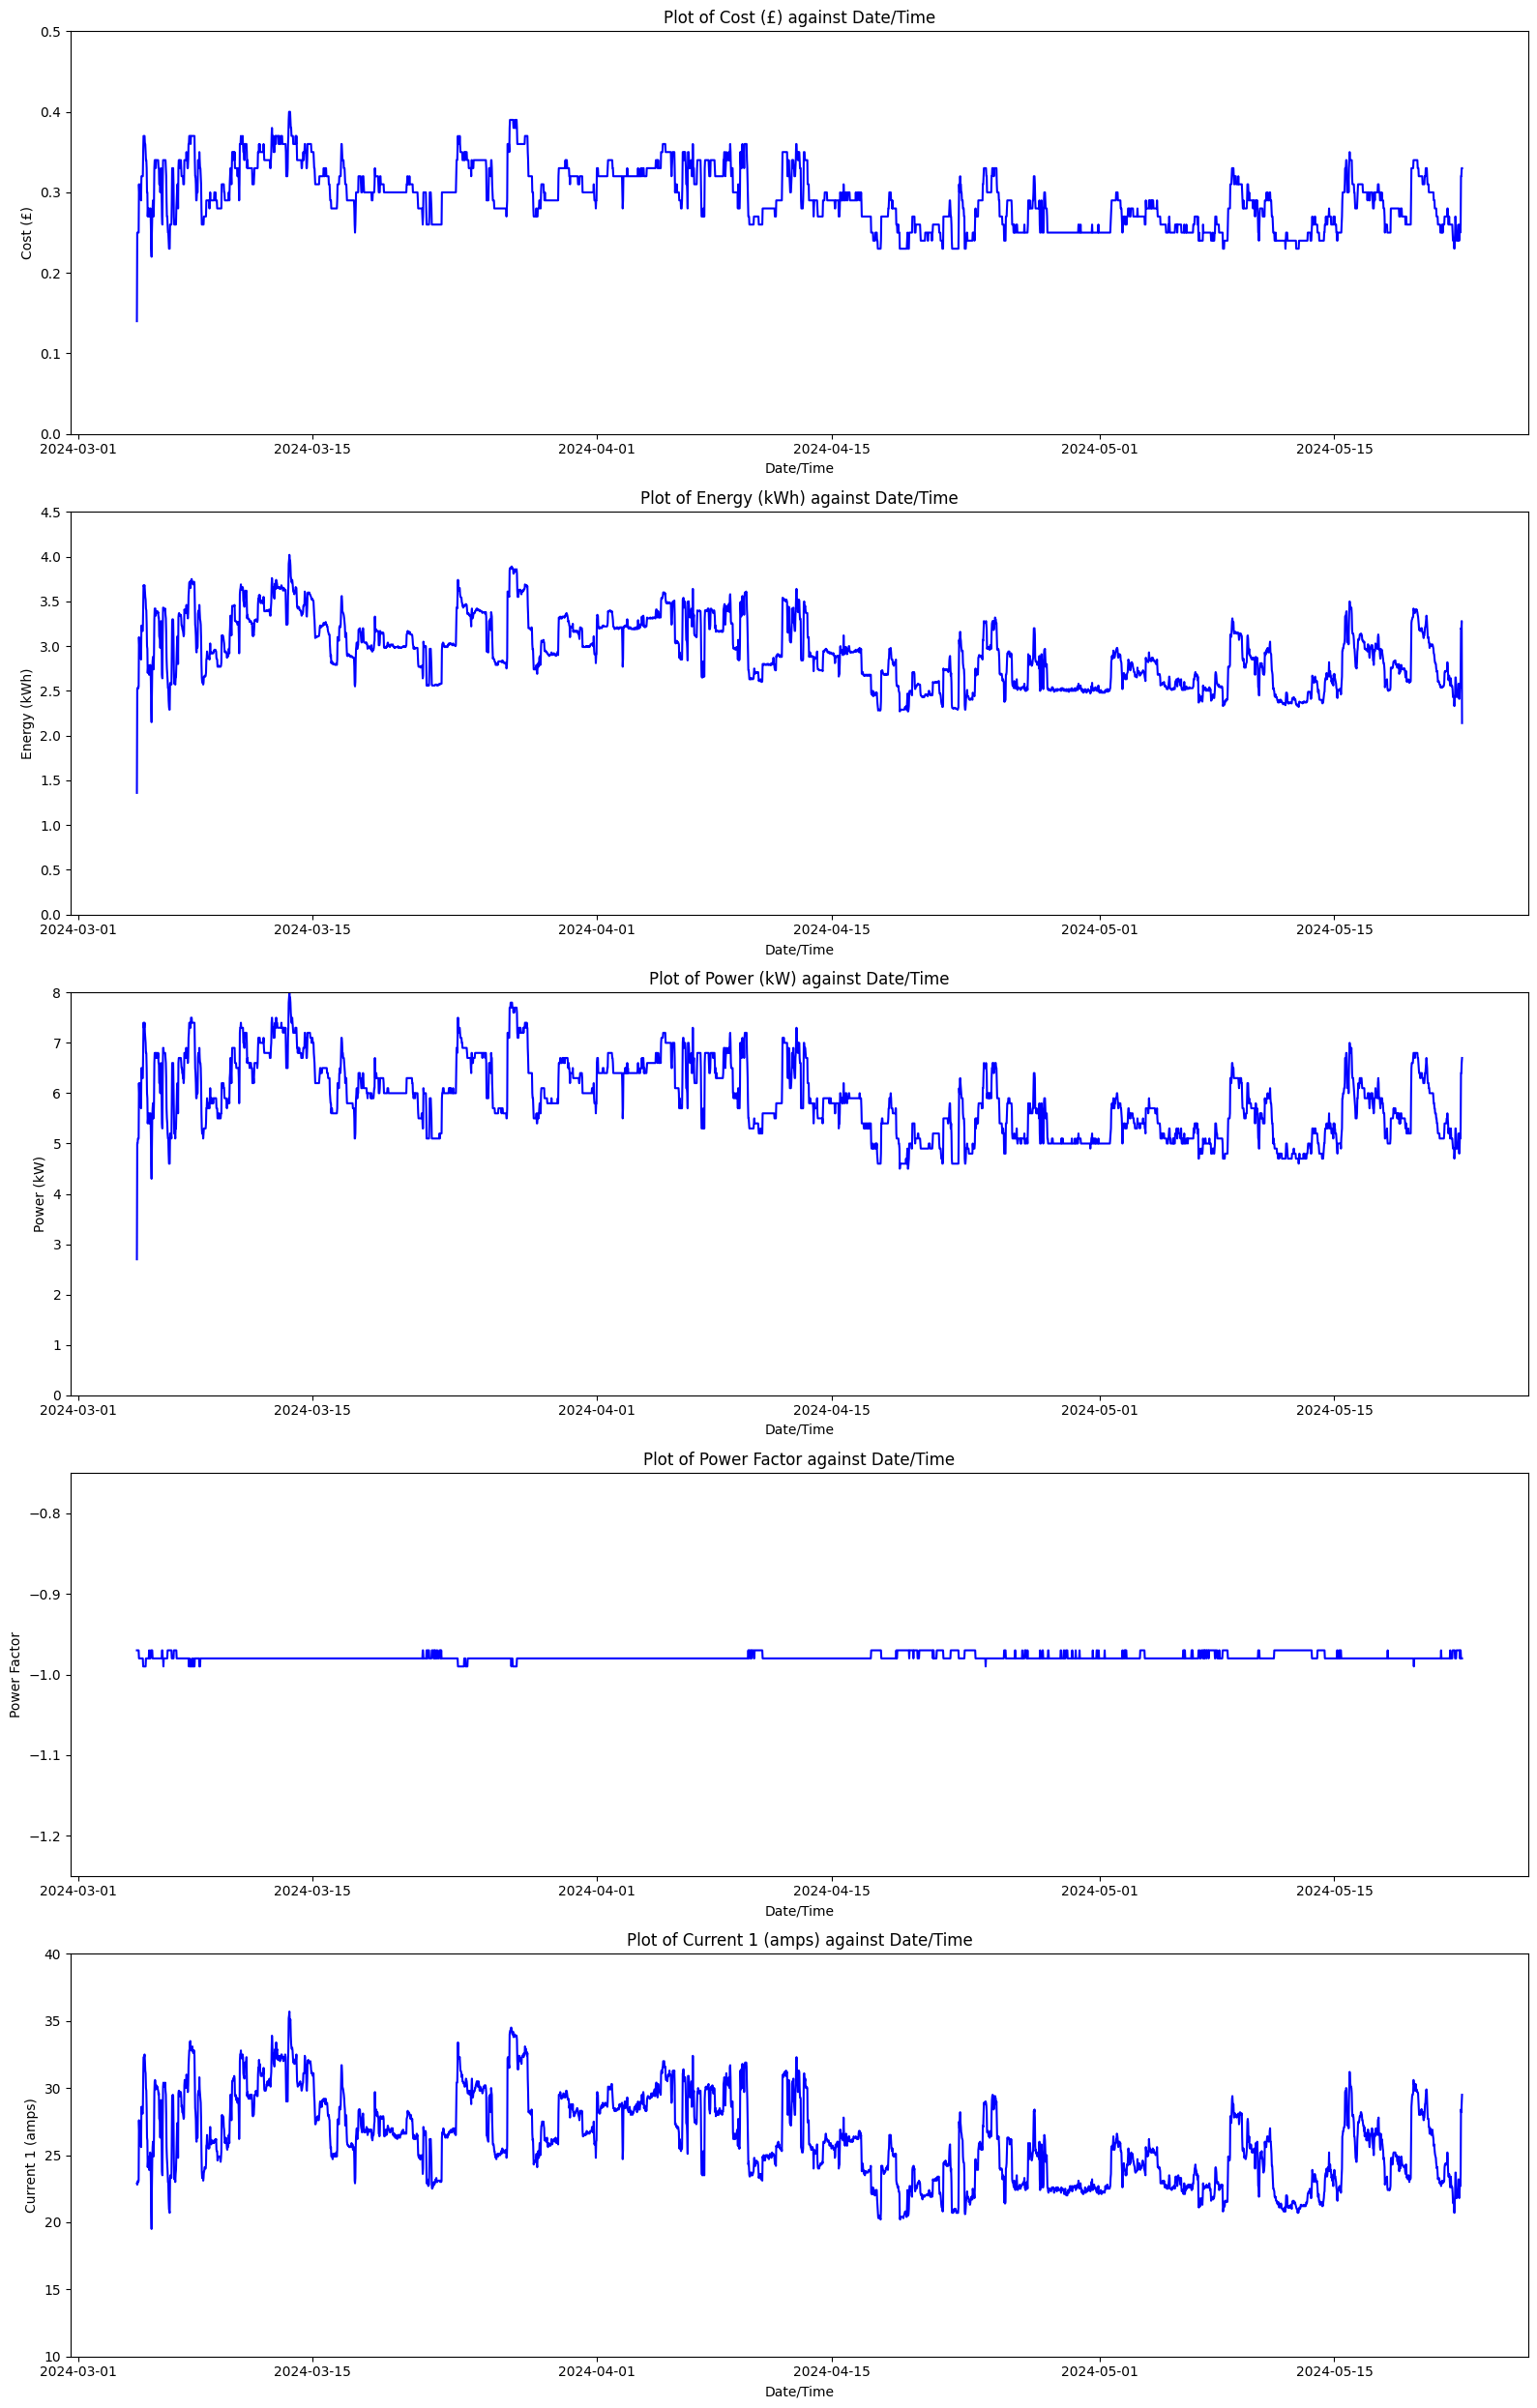

In [239]:
plt.figure(figsize=(16, 5*5))

headers = dl1.columns.values.tolist()

for i in range(1, len(headers)):
    match i:
        case 1: vertical_limits = (0, 0.5)
        case 2: vertical_limits = (0, 4.5)
        case 3: vertical_limits = (0, 8)
        case 4: vertical_limits = (-1.25, -0.75)
        case 5: vertical_limits = (10, 40)
    plt.subplot(5, 1, i)
    plt.plot(dl1["Date/Time"], dl1[headers[i]], color='b')
    plt.ylim(vertical_limits)
    plt.xlabel("Date/Time")
    plt.ylabel(headers[i])
    plt.title("Plot of " + headers[i] + " against Date/Time")
    
plt.tight_layout()
plt.show()

Note that most of these are very similar, as proved by the correlation matrix, where nearly all variables have a correlation coefficient of 1. 

In [240]:
print(dl1.drop(columns=["Date/Time"]).corr())

                  Cost (£)  Energy (kWh)  Power (kW)  Power Factor  \
Cost (£)          1.000000      0.995811    0.995801     -0.582129   
Energy (kWh)      0.995811      1.000000    0.997802     -0.585075   
Power (kW)        0.995801      0.997802    1.000000     -0.585427   
Power Factor     -0.582129     -0.585075   -0.585427      1.000000   
Current 1 (amps)  0.994282      0.995574    0.996145     -0.581830   

                  Current 1 (amps)  
Cost (£)                  0.994282  
Energy (kWh)              0.995574  
Power (kW)                0.996145  
Power Factor             -0.581830  
Current 1 (amps)          1.000000  


This is largely to be expected as power consumption, energy, and cost are linearly linked. 
Assuming the voltage supply remains constant and there are no significant loading effects in the supply of the building, the current is also linearly linked. This relationship will be explored and proved later. 
For this reason, only the power will be plotted in further figures, for ease of readability.


### Important Dates
During these times, there were bank holidays, campus closure times, as well as a switch from term time to holiday time. As the servers are mostly used by MsC and PhD students, usually overnight, it is expected that the power consumption over that time remains relatively constant. Here, we will distiguish between power consumption on weekends, bank holidays, term time, and campus closure.

#### Bank Holidays & Campus Closure
The dates were pulled manually from the official imperial website.

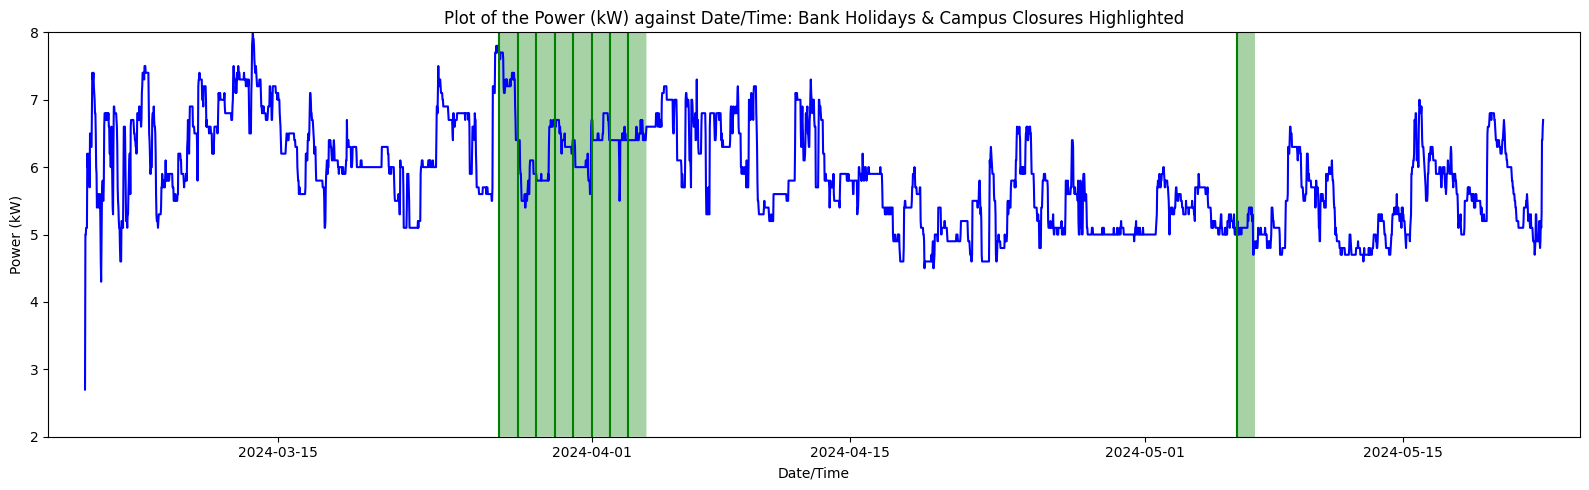

In [241]:
# bank holidays + campus closure
bank_holidays = pd.to_datetime(["27/03/2024", "28/03/2024", "29/03/2024", "30/03/2024", "31/03/2024", "01/04/2024", "02/04/2024", "03/04/2024", 
                 "06/05/2024", "27/05/2024", "26/08/2024"], format='%d/%m/%Y')

# initialize figure
plt.figure(figsize=(16, 5))

header = "Power (kW)"
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[header], color='b')
plt.vlines(bank_holidays, ymin=vertical_limits[0], ymax=vertical_limits[1], colors='g')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.normalize() in bank_holidays for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(header)
plt.title("Plot of the " + header + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.tight_layout()
plt.show()

### Weekends vs Weekdays
Here, it is pertinent to analyse the expected and median power consumption in the two scenarios. It could also be pertinent to analyse variance.

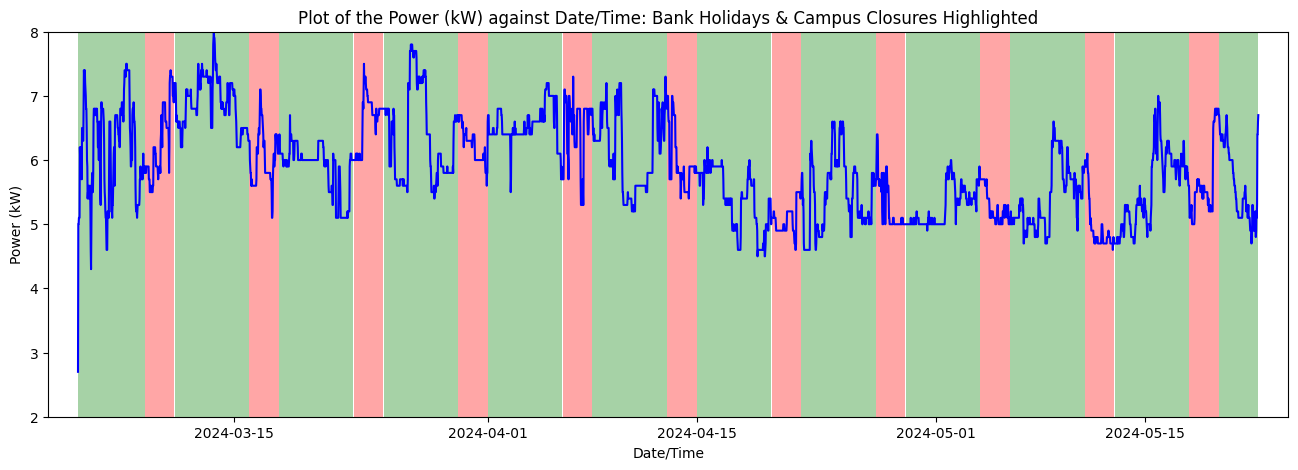

Mean power consumption: 5.872274881516588 kW
Median power consumption: 5.8 kW

Monday
Mean power consumption during weekdays: 5.898978847556528 kW
Mean power consumption during weekends: 5.802935606060606 kW
Median power consumption during weekdays: 5.9 kW
Median power consumption during weekends: 5.7 kW
Mean power consumption on day of the week 0: 5.881306715063521 kW
Mean power consumption on day of the week 1: 5.813541666666667 kW
Mean power consumption on day of the week 2: 5.94293381037567 kW
Mean power consumption on day of the week 3: 6.030681818181819 kW
Mean power consumption on day of the week 4: 5.832386363636363 kW
Mean power consumption on day of the week 5: 5.824053030303031 kW
Mean power consumption on day of the week 6: 5.781818181818182 kW
Median power consumption on day of the week 0: 6.0 kW
Median power consumption on day of the week 1: 5.7 kW
Median power consumption on day of the week 2: 6.0 kW
Median power consumption on day of the week 3: 5.9 kW
Median power cons

In [242]:
plt.figure(figsize=(16, 5))

header = "Power (kW)"
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[header], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() == 5 or time.weekday() == 6 for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() != 5 and time.weekday() != 6 for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(header)
plt.title("Plot of the " + header + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.show()

## Mean and median total consumption
print("Mean power consumption: " + str(dl1[header].mean()) + " kW")
print("Median power consumption: " + str(dl1[header].median()) + " kW\n")

power_days = [[]]*9
for i in range(7):
    power_days[i] = [dl1[header].iloc[j] for j in range(len(dl1)) if dl1["Date/Time"].iloc[j].weekday() == i]
power_days[7] = [dl1[header].iloc[j] for j in range(len(dl1)) if dl1["Date/Time"].iloc[j].weekday() not in (5, 6)]
power_days[8] = [dl1[header].iloc[j] for j in range(len(dl1)) if dl1["Date/Time"].iloc[j].weekday() in (5, 6)]

print(dl1["Date/Time"].iloc[0].day_name())

# power_days[7] = weekdays; power_days[8] = weekends; 
# the rest follows the pd.datetime convetion, assuming Monday == 0
## Now, let's analyse the mean and median in weekends vs weekdays
print("Mean power consumption during weekdays: " + str(np.mean(power_days[7])) + " kW")
print("Mean power consumption during weekends: " + str(np.mean(power_days[8])) + " kW")
print("Median power consumption during weekdays: " + str(np.median(power_days[7])) + " kW")
print("Median power consumption during weekends: " + str(np.median(power_days[8])) + " kW")

## Let's also do the same for all days of the week!
for i in range(0, 7):
    print("Mean power consumption on day of the week " + str(i) + ": " + str(np.mean(power_days[i])) + " kW")
for i in range(0, 7):
    print("Median power consumption on day of the week " + str(i) + ": " + str(np.median(power_days[i])) + " kW")

#### Term Time
Again, term time dates were pulled from Imperial's official website.

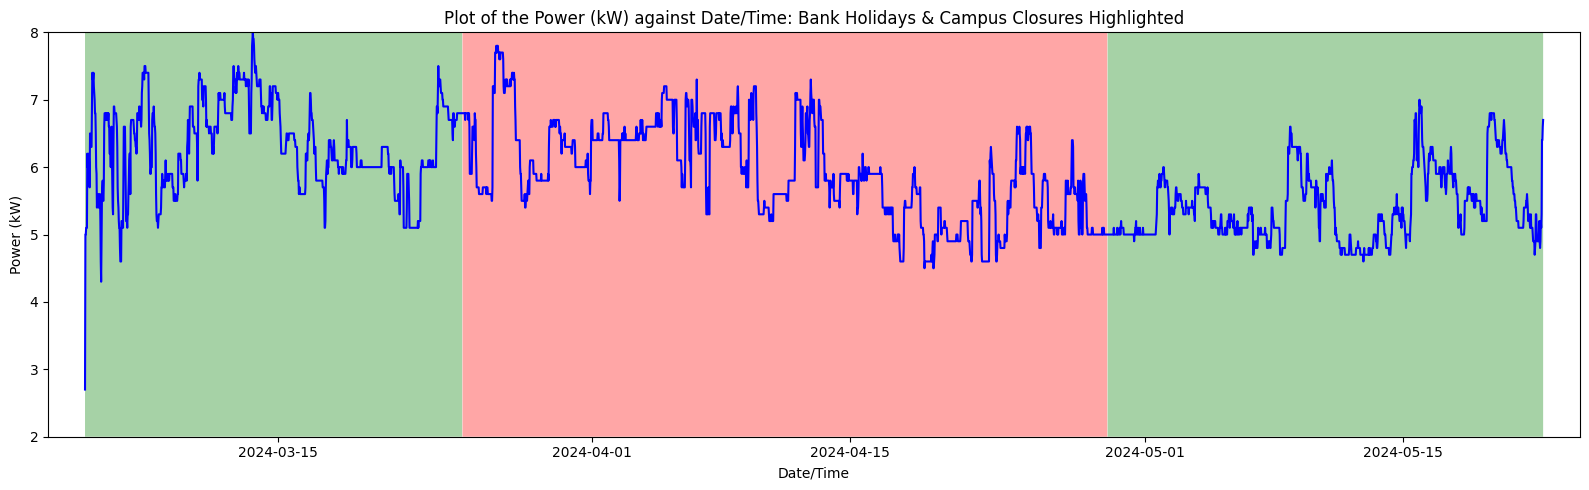

In [243]:
# Term Time relation to power consumption
spring_term = pd.date_range(pd.to_datetime("2024-01-07"), pd.to_datetime("2024-03-24"), freq=pd.Timedelta(days=1))
summer_term = pd.date_range(pd.to_datetime("2024-04-29"), pd.to_datetime("2024-06-30"), freq=pd.Timedelta(days=1))

plt.figure(figsize=(16, 5))

header = "Power (kW)"
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[header], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() not in spring_term and time.normalize() not in summer_term for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() in spring_term or time.normalize() in summer_term for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(header)
plt.title("Plot of the " + header + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.tight_layout()
plt.show()

### Weather Correlation 
Weather data was pulled from
https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/retrievebulkdataset?&key=N5DBBSK9PPTUQXL4HPRMDDYAN&taskId=3765147917cc95e731a8610aab8caed2&zip=false

https://www.visualcrossing.com/weather/weather-data-services#

To import the data, the same process as before can be used, taking care to import the date and time as a pandas datetime.

In [244]:
weather = pd.read_csv("../data/London_Weather_Data.csv").drop(columns=["name", "stations", "icon"])
weather["datetime"] = pd.to_datetime(weather["datetime"], format='%Y-%m-%dT%H:%M:%S')

print(dl1.head)

<bound method NDFrame.head of                Date/Time  Cost (£)  Energy (kWh)  Power (kW)  Power Factor  \
1    2024-03-04 12:30:00      0.14          1.36         2.7         -0.97   
2    2024-03-04 13:00:00      0.25          2.52         5.0         -0.97   
3    2024-03-04 13:30:00      0.25          2.52         5.0         -0.97   
4    2024-03-04 14:00:00      0.25          2.54         5.1         -0.97   
5    2024-03-04 14:30:00      0.25          2.53         5.1         -0.97   
...                  ...       ...           ...         ...           ...   
3794 2024-05-22 13:00:00      0.26          2.65         5.3         -0.97   
3795 2024-05-22 13:30:00      0.32          3.20         6.4         -0.98   
3796 2024-05-22 14:00:00      0.32          3.19         6.4         -0.98   
3797 2024-05-22 14:30:00      0.33          3.28         6.6         -0.98   
3798 2024-05-22 15:00:00      0.33          2.14         6.7         -0.98   

      Current 1 (amps)  
1       

## 2. Frequency Analysis

A possible idea could be to do an FFT: as we know the sample size is 30 mins, we can get an accurate reading of the frequency of the current, up to a precision of 1 hour^-1.

It is interesting to remove the first element of the FFT, as this essentially removes the constant component. We are now left with only the varying parts

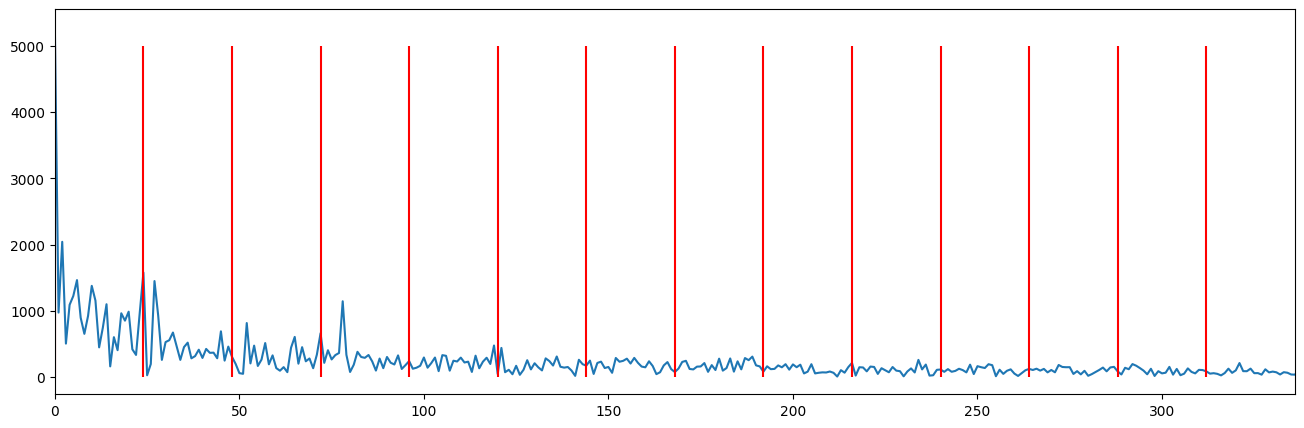

In [245]:
dl1_fft = sp.fft.fft(np.array(dl1["Current 1 (amps)"])) # obtain FFT

# plot real part
plt.figure(figsize=(16, 5))
plt.plot(np.abs(dl1_fft[1:]))
plt.xlim([0, 2*24*7])
plt.vlines(x=range(0, 2*24*7, 24), ymin=0, ymax=5000, colors='r')
plt.show()